# Compare positions obtain from optitrack & predicted from model

In [1]:
from nn import KinematicMLP
import torch

import joblib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px


### Load Model

In [2]:
# Load model
model = KinematicMLP(input_size=9, output_size=9)
model.load_state_dict(torch.load("kinematic_model_v8999.pth"))
model.eval()

# Load actuation sample from saved dataset
scaler_X = joblib.load("scaler_X_8999.save")
scaler_Y = joblib.load("scaler_Y_8999.save")

### Load the actuation data

In [52]:
dt = np.load("data_optitrack/data30_actrange150_date1104_3.npz")

# actual_position_list, act_list, wanted_position_list
actual_position_list = dt["actual_position_list"]
act_list = dt["act_list"]
wanted_position_list = dt["wanted_position_list"]

# Check shape
print(f"actual_position_list shape: {actual_position_list.shape}")
print(f"act_list shape: {act_list.shape}")
print(f"wanted_position_list shape: {wanted_position_list.shape}")

actual_position_list shape: (30, 3, 3)
act_list shape: (30, 3, 3)
wanted_position_list shape: (30, 3, 3)


In [54]:
# delete the first element of the actual_position_list
actual_position_list = np.delete(dt["actual_position_list"], 0, axis=0)
safe_position = actual_position_list[0]

print(f"safe_position: {safe_position}")
# Subtract all actual_position_list by the first element to get the relative position -> delta L
actual_position_list = actual_position_list - safe_position
actual_position_list[0:5]

safe_position: [[10277. 12388.  9822.]
 [ 5798.  9290. 10541.]
 [14466.  9774. 10124.]]


array([[[   0.,    0.,    0.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.]],

       [[ -77.,   -3.,  172.],
        [ -29.,    0.,  133.],
        [ -77.,  -34.,   98.]],

       [[  46., -109.,  172.],
        [  28.,  -87.,  133.],
        [   0., -127.,   99.]],

       [[ 107., -123.,  149.],
        [  83., -109.,  133.],
        [  57., -153.,   84.]],

       [[   5.,  -67.,  149.],
        [  52.,  -73.,  133.],
        [   5.,  -71.,   84.]]])

In [55]:

# INPUT -->  flatten the actions list
X = actual_position_list.reshape(actual_position_list.shape[0], -1)
print("actual position shape: ", X.shape)

actual position shape:  (29, 9)


### Prediction:

In [56]:
# Normalize the input data using the scaler
X_norm = scaler_X.fit_transform(X)
# Convert to torch tensor
X_tensor = torch.tensor(X_norm, dtype=torch.float32)

# Predict the output "y" using the model (positions)
Y_pred = model(X_tensor).detach().numpy()
# Inverse transform the predicted output using the scaler
Y_pred_inv = scaler_Y.inverse_transform(Y_pred)

# Reshape the predicted output to match the original shape 
# Extract only the first 9 values
Y_pred_inv = Y_pred_inv[:, :9]
Y_pred_reshaped = Y_pred_inv.reshape(actual_position_list.shape[0], 3, 3)
print("Y_pred shape: ", Y_pred_reshaped.shape)

# Extract only the positions of x,y,z of end effector
predict_end_effector_positions = Y_pred_reshaped[:, 2, :]
print("predict_end_effector_positions shape: ", predict_end_effector_positions.shape)

Y_pred shape:  (29, 3, 3)
predict_end_effector_positions shape:  (29, 3)


### Visualization

In [57]:
# Define step size
step = 1

# Create 3D scatter plot
fig = go.Figure()

# Section 0 trajectory
fig.add_trace(go.Scatter3d(
    x=Y_pred_reshaped[::step, 0, 0], 
    y=Y_pred_reshaped[::step, 0, 1], 
    z=Y_pred_reshaped[::step, 0, 2], 
    mode='markers', 
    marker=dict(color='blue', size=3),
    name="low"
))

# Section 1 trajectory
fig.add_trace(go.Scatter3d(
    x=Y_pred_reshaped[::step, 1, 0], 
    y=Y_pred_reshaped[::step, 1, 1], 
    z=Y_pred_reshaped[::step, 1, 2], 
    mode='markers', 
    marker=dict(color='green', size=3),
    name="middle"
))

# Section 2 trajectory
fig.add_trace(go.Scatter3d(
    x=Y_pred_reshaped[::step, 2, 0], 
    y=Y_pred_reshaped[::step, 2, 1], 
    z=Y_pred_reshaped[::step, 2, 2], 
    mode='markers', 
    marker=dict(color='red', size=3),
    name="up"
))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show interactive figure
fig.show()


### Load the ground truth data

In [58]:
# Load the ground truth data
data = pd.read_csv("optitrack_data_full_bodies_data30_actrange150_date1104_3.csv")

# delete the last row of the dataframe
data = data[:-1]

print(data.shape)
data.tail(5)

(29, 25)


,Timestamp,SA-base-X,SA-base-Y,SA-base-Z,SA-base-Roll,SA-base-Pitch,SA-base-Yaw,SA-low-X,SA-low-Y,SA-low-Z,...,SA-middle-Z,SA-middle-Roll,SA-middle-Pitch,SA-middle-Yaw,SA-up-X,SA-up-Y,SA-up-Z,SA-up-Roll,SA-up-Pitch,SA-up-Yaw
24,1.744358e+09,0.068008,0.139917,-0.172508,-0.918917,-0.135195,-0.421835,0.069499,0.350843,-0.214796,...,-0.209971,-2.417286,0.300458,-4.055253,0.103878,0.768210,-0.212954,-6.592954,0.580675,-3.440134
25,1.744358e+09,0.068007,0.139899,-0.172497,-0.914940,-0.129283,-0.411774,0.065666,0.350767,-0.213355,...,-0.202865,-0.307863,0.310027,0.495627,0.071474,0.769212,-0.197399,-4.491129,0.522388,0.333256
26,1.744358e+09,0.067892,0.139883,-0.172207,-1.052642,0.162652,-0.390052,0.069706,0.350897,-0.217056,...,-0.211206,-0.899323,0.185472,1.667613,0.070239,0.769379,-0.212146,-7.019139,0.444511,3.116158
27,1.744358e+09,0.068134,0.139976,-0.172459,-0.632465,-0.512632,-0.311145,0.074373,0.350866,-0.216163,...,-0.206483,0.628646,0.123768,-0.044327,0.085137,0.768600,-0.198676,-4.307183,0.151577,3.669684
28,1.744358e+09,0.068063,0.139900,-0.172508,-0.837432,-0.154175,-0.396477,0.068484,0.350911,-0.216413,...,-0.208344,-0.048109,0.228181,2.553988,0.059761,0.768958,-0.200827,-3.512180,0.190719,5.417414


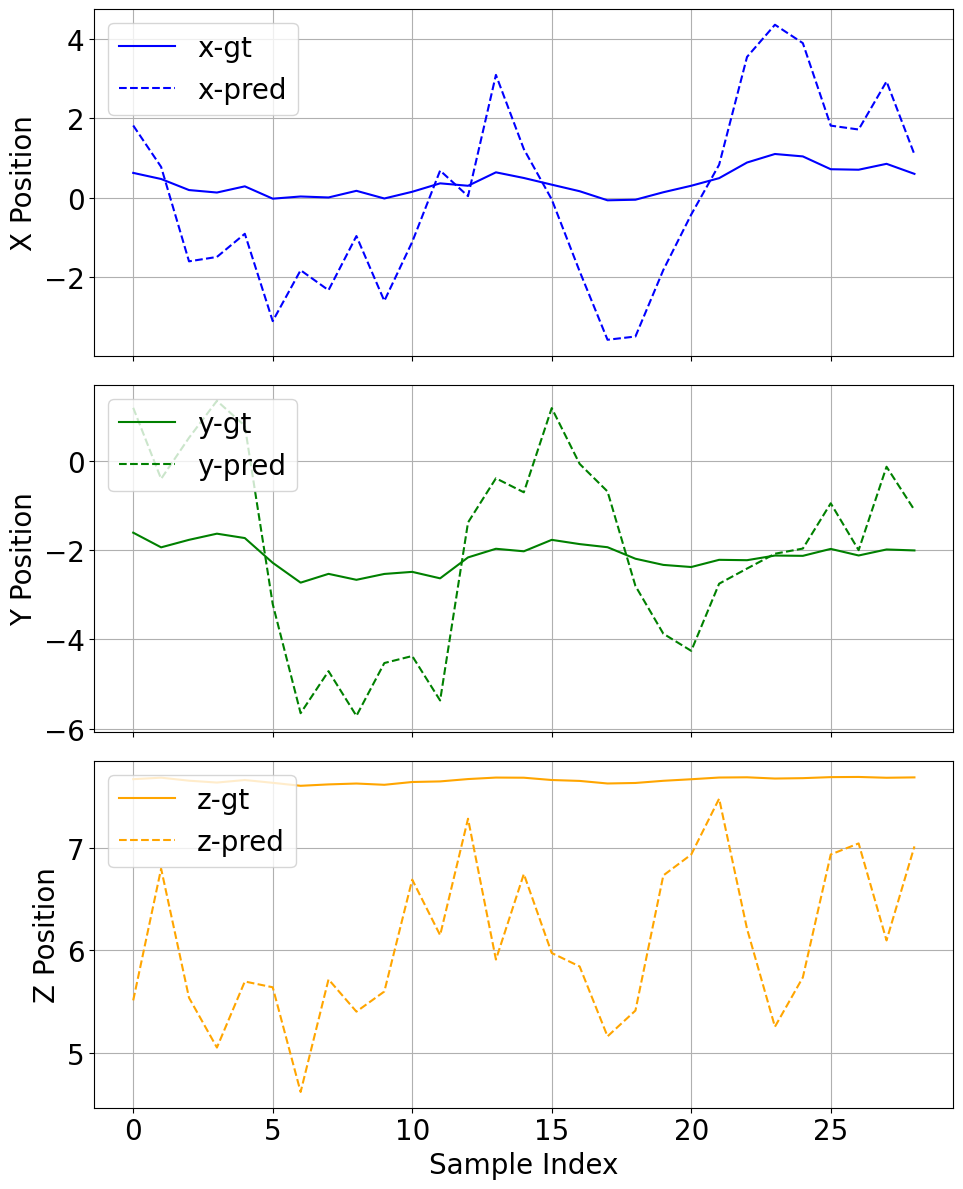

In [ ]:
# 9 inputs

# Create subplots for x, y, z
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# X-axis
axs[0].plot(data["SA-up-X"], label="x-gt", color="blue")
axs[0].plot(predict_end_effector_positions[:, 0]*10, label="x-pred", color="blue", linestyle='--')
axs[0].set_ylabel("X Position", fontsize=20)
axs[0].legend(fontsize=20, loc='upper left')
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=20)

# Y-axis
axs[1].plot(data["SA-up-Z"], label="y-gt", color="green")
axs[1].plot(predict_end_effector_positions[:, 2]*10, label="y-pred", color="green", linestyle='--')
axs[1].set_ylabel("Y Position", fontsize=20)
axs[1].legend(fontsize=20, loc='upper left')
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=20)

# Z-axis
axs[2].plot(data["SA-up-Y"], label="z-gt", color="orange")
axs[2].plot(predict_end_effector_positions[:, 1]*10, label="z-pred", color="orange", linestyle='--')
axs[2].set_ylabel("Z Position", fontsize=20)
axs[2].set_xlabel("Sample Index", fontsize=20)
axs[2].legend(fontsize=20, loc='upper left')
axs[2].grid()
axs[2].tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()


### Show both true position (optitrack) & predicted position (kinematic model)

In [12]:
step = 1  # step size for visualization clarity

fig = go.Figure()

sections = ["low", "middle", "up"]
colors_pred = ["blue", "green", "red"]
colors_gt = ["turquoise", "yellow", "orange"]

# Plot predicted points
for i, section in enumerate(sections):
    fig.add_trace(go.Scatter3d(
        x=Y_pred_reshaped[::step, i, 0], 
        y=Y_pred_reshaped[::step, i, 1], 
        z=Y_pred_reshaped[::step, i, 2],
        mode='markers',
        marker=dict(size=3, color=colors_pred[i], symbol='circle'),
        name=f"Prediction-{section}"
    ))

# Plot ground truth points
for i, section in enumerate(sections):
    fig.add_trace(go.Scatter3d(
        x=data[f"SA-{section}-X"][::step], 
        y=data[f"SA-{section}-Y"][::step], 
        z=data[f"SA-{section}-Z"][::step],
        mode='markers',
        marker=dict(size=3, color=colors_gt[i], symbol='square'),
        name=f"GT-{section}"
    ))

min_length = min(len(Y_pred_reshaped), len(data[f"SA-{section}-X"]))

# Add lines connecting corresponding predicted and ground truth points
for i, section in enumerate(sections):
    for j in range(0, min_length, step):
        fig.add_trace(go.Scatter3d(
            x=[Y_pred_reshaped[j, i, 0], data[f"SA-{section}-X"][j]],
            y=[Y_pred_reshaped[j, i, 1], data[f"SA-{section}-Y"][j]],
            z=[Y_pred_reshaped[j, i, 2], data[f"SA-{section}-Z"][j]],
            mode='lines',
            line=dict(width=1, color='gray', dash='dot'),
            showlegend=False  # Avoid cluttering the legend
        ))

fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(itemsizing='constant', bgcolor="rgba(255,255,255,0.8)")
)

fig.show()


### Show where errors are the most bigger

In [13]:
errors = {}

for i, section in enumerate(sections):
    pred_points = Y_pred_reshaped[:, i, :]
    gt_points = np.stack([
        data[f"SA-{section}-X"],
        data[f"SA-{section}-Y"],
        data[f"SA-{section}-Z"]
    ], axis=-1)

    # Select the minimum length to ensure shape matching
    min_length = min(pred_points.shape[0], gt_points.shape[0])
    pred_points = pred_points[:min_length]
    gt_points = gt_points[:min_length]

    
    diff = pred_points - gt_points
    euclidean_distance = np.linalg.norm(diff, axis=1)

    errors[section] = {
        "mean_error": np.mean(euclidean_distance),
        "std_error": np.std(euclidean_distance)
    }

for section, stats in errors.items():
    print(f"Section '{section}': Mean Error = {stats['mean_error']:.3f}, Std Dev = {stats['std_error']:.3f}")

Section 'low': Mean Error = 0.036, Std Dev = 0.011
Section 'middle': Mean Error = 0.096, Std Dev = 0.042
Section 'up': Mean Error = 0.170, Std Dev = 0.082


In [14]:
step = 1  # step size
sections = ["low", "middle", "up"]
gt_colors = ["blue", "green", "red"]

fig = go.Figure()

# Add ground truth data
for i, section in enumerate(sections):
    fig.add_trace(go.Scatter3d(
        x=data[f"SA-{section}-X"][::step], 
        y=data[f"SA-{section}-Y"][::step], 
        z=data[f"SA-{section}-Z"][::step],
        mode='markers',
        marker=dict(size=4, color=gt_colors[i], symbol='square'),
        name=f"GT-{section}"
    ))

# Combine predictions and errors for colorbar
all_pred_x, all_pred_y, all_pred_z, all_errors = [], [], [], []

for i, section in enumerate(sections):
    # Predicted and ground truth points
    pred_points = Y_pred_reshaped[:, i, :]
    gt_points = np.stack([
        data[f"SA-{section}-X"],
        data[f"SA-{section}-Y"],
        data[f"SA-{section}-Z"]
    ], axis=-1)

    min_length = min(len(pred_points), len(gt_points))
    pred_points = pred_points[:min_length]
    gt_points = gt_points[:min_length]

    errors = np.linalg.norm(pred_points - gt_points, axis=1)

    all_pred_x.extend(pred_points[:, 0])
    all_pred_y.extend(pred_points[:, 1])
    all_pred_z.extend(pred_points[:, 2])
    all_errors.extend(errors)

    # Optional: Add lines between corresponding points
    for j in range(0, min_length, step):
        fig.add_trace(go.Scatter3d(
            x=[pred_points[j, 0], gt_points[j, 0]],
            y=[pred_points[j, 1], gt_points[j, 1]],
            z=[pred_points[j, 2], gt_points[j, 2]],
            mode='lines',
            line=dict(width=1, color='gray', dash='dot'),
            showlegend=False
        ))

# Normalize errors for colorbar
errors_array = np.array(all_errors)
marker_colors = errors_array

# Predicted points with a colorbar (legend)
scatter_pred = go.Scatter3d(
    x=all_pred_x, 
    y=all_pred_y, 
    z=all_pred_z,
    mode='markers',
    marker=dict(
        size=4,
        color=marker_colors,
        colorscale='Viridis',
        colorbar=dict(
            title=dict(
                text="Prediction Error<br>(distance)",
                side="top"
            ),
            len=0.75,
            thickness=15,
        ),
        showscale=True
    ),
    name="Predictions"
)

fig.add_trace(scatter_pred)

# Update layout clearly
fig.update_layout(
    title="Prediction vs. Ground Truth (Color Indicates Accuracy)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,   # Move legend to the left (0 is the left edge)
        y=1,   # Position at the top
        xanchor='left',  # Align legend to the left
        yanchor='top'    # Align legend to the top
    )
)

fig.show()
